# Analysis

## Settings

In [1]:
# %matplotlib widget
%matplotlib inline

In [23]:
import csv
import configparser
import numpy as np
from datetime import datetime, timedelta
from carst.libdhdt import DemPile
import pandas as pd
import geopandas as gpd
from osgeo import gdal
import pathlib
import icepyx as ipx

import io
from fiona.io import ZipMemoryFile
import os

from atl06lib import read_atl06, read_h5
import dask.dataframe as dd
from scipy.stats import median_abs_deviation

from carst.libdhdt import gaussian_process_reg as gpr
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel
from scipy.signal import argrelextrema
from carst.libraster import SingleRaster

import matplotlib.pyplot as plt

## Parameters

In [3]:
tag = 'YelvertonNW'                         # Must match the refgeo tag
arcticdem_index = '../ArcticDEM_Strip_Index_s2s041_3-ACN.gpkg'
rgi_index = '../nsidc0770_03.rgi60.ArcticCanadaNorth.zip'
# n_workers = 64                          # Number of workers, for parallel computing
# parallel_chunksize = (1000, 1000)       # Chucksize of pile.ts for parallel computing
# # parallel_chunksize = (1000, 1000) or (500, 500) is ideal 
# # for my computing env where I have 64 CPUs and ~900 GBs of memory.
# # ====
min_samples = 3
# # minimum samples required for DBSCAN to confirm elevation clusters.
# # ====
use_pickled_data = True
# If a specific step is included in do_steps, then that step will be executed.
# do_evmd = True
# do_polyfit = True
# do_mosaic = True
# # if True, the program will do the corresponding steps.
# # if False, the program will skip the corresponding steps. If all skipped, the program will just visualize the results.
# # ====

if_additional_exclusion = True   # To be used in step 4

do_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9]
working_epsg = 3413
office_buffer = 250   # To be used in step 4

deminput = 'deminput.csv'
dem_summary = 'dem_summary.csv'   # To be used in step 6
processed_deminput = 'deminput_processed.csv'
buffer_size = 30   # To be used in step 2
dem_subsets_folder = './DEM_subsets'  # To be used in step 2
bitmask_subsets_folder = './DEMBitmask_subsets'  # To be used in step 2
altimetry_subsets_folder = './Altimetry_subsets'  # To be used in step 3
altimetry_acq_time = ['2018-01-01','2022-01-01']  # To be used in step 3
altimetry_acq_cycles = ['03', '04', '07', '08', '11', '12']  # To be used in step 3

altimetry_processed_folder = './Altimetry_processed'  # To be used in step 4
dem_processed_folder = './DEM_processed'  # To be used in step 5

In [4]:
dhdt_prefix = tag + '_15m'
refgeo = 'refgeo-' + tag + '_15m.tif'
refgeo_gpkg = 'refgeo-' + tag + '.gpkg'
picklefile = 'refgeo-' + tag + '_15m_TSpickle.p'
inipath = 'defaults.ini'
refdate = datetime(2015, 1, 1)

if if_additional_exclusion:
    additional_exclusion_gpkg = tag + '-off-ice-exclusion.gpkg'
    additional_exclusion_refgeo = gpd.read_file(additional_exclusion_gpkg)
    additional_exclusion_poly = additional_exclusion_refgeo.geometry.unary_union

gdf_refgeo = gpd.read_file(refgeo_gpkg)
poly_refgeo = gdf_refgeo.geometry.unary_union

dem_processed_path = pathlib.Path(dem_processed_folder)
dem_processed_path.mkdir(exist_ok=True)

## Step 1: Acquire DEM list

In [5]:
def clip_extent(gdf, poly):
    gdf_sub = gdf.iloc[gdf.sindex.query(poly, predicate="intersects")]
    clipped = gdf_sub.copy()
    clipped["geometry"] = gdf_sub.intersection(poly)
    return clipped

In [6]:
if 1 in do_steps:
    print('Doing Step 1...')
    gdf_arcticdem = gpd.read_file(arcticdem_index)
    geom_intersection = clip_extent(gdf_arcticdem, poly_refgeo)

    with open(deminput, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['filename', 'date', 'uncertainty'])

        for s3url in geom_intersection.s3url:
            dem_url = s3url.replace('https://polargeospatialcenter.github.io/stac-browser/#/external/', 
                                    '/vsicurl/https://') # Specify COG driver
            dem_url = dem_url.replace('.json', '_dem.tif')
            date = dem_url.split('_')[3]  # yyyymmdd
            date = date[:4] + '-' + date[4:6] + '-' + date[6:]  # yyyy-mm-dd
            uncertainty = '4'
            writer.writerow([dem_url, date, uncertainty])
else:
    print('Step 1 skipped')

Doing Step 1...


## Step 2: Download Subset DEMs

In [7]:
if 2 in do_steps:
    print('Doing Step 2...')

    pathlib.Path(dem_subsets_folder).mkdir(exist_ok=True)
    pathlib.Path(bitmask_subsets_folder).mkdir(exist_ok=True)

    x1, y1, x2, y2 = poly_refgeo.bounds
    x1 -= buffer_size
    y1 -= buffer_size
    x2 += buffer_size
    y2 += buffer_size

    with open(deminput, newline='') as f:
        csvcontent = csv.reader(f, skipinitialspace=True)
        next(csvcontent, None)    # Skip the header
        for row in csvcontent:
            cog_path = row[0]
            ds = gdal.Open(cog_path)
            original_filename = pathlib.Path(cog_path).name
            ds = gdal.Translate(f'{dem_subsets_folder}/processed-{original_filename}', ds, projWin = [x1, y2, x2, y1])
            ds = None
            bitmask_cog_path = cog_path.replace('dem.tif', 'bitmask.tif')
            ds = gdal.Open(bitmask_cog_path)
            original_filename = pathlib.Path(bitmask_cog_path).name
            ds = gdal.Translate(f'{bitmask_subsets_folder}/processed-{original_filename}', ds, projWin = [x1, y2, x2, y1])
            ds = None
            
else:
    print('Step 2 skipped')

Doing Step 2...


## Step 3: Acquire ICESat-2 ATL-6 points

Needs a login credentials now

In [8]:
if 3 in do_steps:
    print('Doing Step 3...')

    refgeo_latlon = gdf_refgeo.to_crs(epsg=4326)
    refgeo_poly_latlon = refgeo_latlon.geometry.unary_union
    xx, yy = refgeo_poly_latlon.exterior.coords.xy
    refgeo_poly_vertices = np.column_stack((xx, yy))

    short_name = "ATL06"
    version = '006'
    region_a = ipx.Query("ATL06", spatial_extent=refgeo_poly_vertices, date_range=altimetry_acq_time, cycles=altimetry_acq_cycles, version='006')
    print(region_a.avail_granules())
    
    pathlib.Path(altimetry_subsets_folder).mkdir(exist_ok=True)
    
    region_a.download_granules(altimetry_subsets_folder)
    
else:
    print('Step 3 skipped')

Doing Step 3...
{'Number of available granules': 94, 'Average size of granules (MB)': 15.232019931712049, 'Total size of all granules (MB)': 1431.8098735809326}
NSIDC only allows ordering of one granule by name at a time; your orders will be placed accordingly.
Total number of data order requests is  1  for  16  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000005185861
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
NSIDC returned these messages
['Granule 267004022 contained no data within the spatial and/or temporal '
 'subset constraints to be processed',
 'Granule 267004015 contained no data within the spatial and/or temporal '
 'subset constraints to be processed',
 'Granule 267293349 contained no data within the spatial and/or temporal '
 'subset constraints to be processed',
 'Granule 267293523 contained no data wi

In [9]:
# icesat2_searching_area

## Step 4: Filter ICESat-2 ATL-6 points (over good bedrock)

In [10]:
if 4 in do_steps:
    print('Doing Step 4...')
    
    alt_processed_path = pathlib.Path(altimetry_processed_folder)
    alt_processed_path.mkdir(exist_ok=True)
    
    alt_raw_path = pathlib.Path(altimetry_subsets_folder)
    files = list(alt_raw_path.glob('*.h5'))
    for f in files:
        read_atl06(f, epsg=working_epsg, outdir=altimetry_processed_folder, bbox=None)
    
    fin_files = list(alt_processed_path.glob('*.h5'))
    
    dfs = []
    for f in fin_files:
        f_data, vnames = read_h5(f)
        dd_data = dd.from_array(f_data, columns=vnames)
        dfs.append(dd_data)

    # Single parallel dataframe (larger than memory)
    df = dd.concat(dfs)

    # dask dataframe convert to pandas dataframe
    df_atl06 = df.compute()
    # print('Number of points:', len(df_atl06))
    
    zipshp = io.BytesIO(open(rgi_index, 'rb').read())

    with (ZipMemoryFile(zipshp)) as memfile:
        with memfile.open() as src:
            crs = src.crs
            gdf_rgi = gpd.GeoDataFrame.from_features(src, crs=crs)

    gdf_rgi = gdf_rgi.to_crs(epsg=working_epsg)
    gdf_rgi_summary_polygon = gdf_rgi.geometry.unary_union
    # gdf_rgi_summary_polygon
    icesat2_searching_area = poly_refgeo.difference(gdf_rgi_summary_polygon.buffer(office_buffer))
    if if_additional_exclusion:
        icesat2_searching_area = icesat2_searching_area.difference(additional_exclusion_poly)
    # icesat2_searching_area
    
    gdf_atl06 = gpd.GeoDataFrame(df_atl06, geometry=gpd.points_from_xy(df_atl06['x'], df_atl06['y']), crs=f'EPSG:{working_epsg}')
    pt_gs = gpd.GeoSeries(gdf_atl06.geometry)
    office_idx = pt_gs.within(icesat2_searching_area)
    gdf_office = gdf_atl06.iloc[np.where(office_idx)]

    ref_h = np.column_stack((gdf_office['x'], gdf_office['y'], gdf_office['h_li']))
    np.savetxt('ref_elevs.csv', ref_h, delimiter = ",", header="x,y,h_li", comments="")
    
else:
    print('Step 4 skipped')

Doing Step 4...
skeeping group: /gt1l
in file: Altimetry_subsets/processed_ATL06_20200913104132_12230804_006_02.h5
skeeping group: /gt1r
in file: Altimetry_subsets/processed_ATL06_20200913104132_12230804_006_02.h5
skeeping group: /gt2l
in file: Altimetry_subsets/processed_ATL06_20200913104132_12230804_006_02.h5
skeeping group: /gt2r
in file: Altimetry_subsets/processed_ATL06_20200913104132_12230804_006_02.h5
out -> Altimetry_processed/processed_ATL06_20200913104132_12230804_006_02_gt3l.h5
out -> Altimetry_processed/processed_ATL06_20200913104132_12230804_006_02_gt3r.h5
out -> Altimetry_processed/processed_ATL06_20200514061700_07440704_006_01_gt1l.h5
out -> Altimetry_processed/processed_ATL06_20200514061700_07440704_006_01_gt1r.h5
out -> Altimetry_processed/processed_ATL06_20200514061700_07440704_006_01_gt2l.h5
out -> Altimetry_processed/processed_ATL06_20200514061700_07440704_006_01_gt2r.h5
out -> Altimetry_processed/processed_ATL06_20200514061700_07440704_006_01_gt3l.h5
out -> Altimet

## Step 5: Align every DEMs with ICESat-2 reference points

Includes uncertainty calculation

In [11]:
if 5 in do_steps:
    print('Doing Step 5...')
    
    with open('do_steps.tmp', 'w') as f:
        for i in do_steps:
            f.write(f"{i}\n")
            
    with open('projwin.tmp', 'w') as f:
        f.write(f"{x1+1} {y1+1} {x2-1} {y2-1}")
    
else:
    print('Step 5 skipped')

Doing Step 5...


In [12]:
%%bash

if grep -q 5 do_steps.tmp; then
    echo "Doing Step 5..."
    
    asp_root=/home/whyjz278/Software/StereoPipeline-3.3.0-Linux/bin
    proj4_str='+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs'
    csvformat_str='1:easting 2:northing 3:height_above_datum'
    atl06_ref=ref_elevs.csv
    projwin_str=$(cat projwin.tmp)
    
    for i in $(ls DEM_subsets/*.tif); do
        # i='DEM_subsets/processed-SETSM_s2s041_W2W2_20120419_103001001200B900_1030010013639500_2m_lsf_seg1_dem.tif'
        filename=${i##*/}
        prefix_str=DEM_processed/asp-${filename%_*}

        ${asp_root}/pc_align --max-displacement 30 --tif-compress=NONE --save-inv-transformed-reference-points --threads 16 \
                             --csv-proj4 "$proj4_str" --csv-format "$csvformat_str" --compute-translation-only \
                             $i ${atl06_ref} -o ${prefix_str}

        ${asp_root}/point2dem ${prefix_str}-trans_reference.tif --nodata-value -9999 -o ${prefix_str} \
                              --t_srs "$proj4_str" --dem-spacing 2 --threads 16 --tif-compress None \
                              --t_projwin ${projwin_str}

        mv ${prefix_str}-DEM.tif ${prefix_str}_dem.tif
        # cd DEM_subsets
        # ln -sf ../DEMBitmask_subsets/${filename%_*}_bitmask.tif asp-${filename%_*}_bitmask.tif
        # cd ..
    done
                   
    cd DEM_processed
    for i in $(ls ../DEMBitmask_subsets/*bitmask.tif); do
        bitmask_orig_filename=${i##*/}
        ln -sf $i asp-${bitmask_orig_filename}
    done
    cd ../
fi

Doing Step 5...
	--> Setting number of processing threads to: 16
Writing log info to: DEM_processed/asp-processed-SETSM_s2s041_W1W3_20170725_10200100648C3800_1040010030966D00_2m_lsf_seg1-log-pc_align-02-06-2240-1002.txt
Detected datum from DEM_subsets/processed-SETSM_s2s041_W1W3_20170725_10200100648C3800_1040010030966D00_2m_lsf_seg1_dem.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the intersection of the bounding boxes of the reference and source points using 9000000 sample points.
Reference box: (Origin: (-82.2024, 81.7383) width: 0.286816 height: 0.0836173)
Source box:    (Origin: (-82.1192, 81.7251) width: 0.969858 height: 0.134396)
Intersection reference

writing to DEM_processed/asp-processed-SETSM_s2s041_W1W3_20170725_10200100648C3800_1040010030966D00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750079
Alignment took 1.84022 [s]
Number of errors: 3165
Output: error percentile of smallest errors (meters): 16%: 0.769816, 50%: 2.63357, 84%: 7.49278
Output: mean of smallest errors (meters): 25%: 0.605318, 50%: 1.24911, 75%: 2.08452, 100%: 4.61272
Final error computation took 0.01114 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  4.502972761241836
                 0                  1                  0  6.766309695434757
                 0                  0                  1 -14.99145026411861
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(127712.71,-906667.4,6291693.8)
Centroid of source points (lat,lon,z): Vector3(81.774644,-81.982096,775.18859)

Translation vector (Cartesian, meters): Vector3(4.5029728,6.7663097,-14.99145)
Translation vector (North-East-Down, meters): Vector3(3.8648356,5.4027361,15.705947)
Translation

writing to DEM_processed/asp-processed-SETSM_s2s041_W2W2_20120419_103001001200B900_1030010013639500_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750034
Alignment took 6.3261 [s]
Number of errors: 14498
Output: error percentile of smallest errors (meters): 16%: 0.168392, 50%: 0.600773, 84%: 1.62077
Output: mean of smallest errors (meters): 25%: 0.130883, 50%: 0.275401, 75%: 0.47156, 100%: 0.985925
Final error computation took 0.031866 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 -2.060537233657669
                 0                  1                  0 0.1366171278059483
                 0                  0                  1 -3.376210579648614
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(129814.99,-906965.46,6291542)
Centroid of source points (lat,lon,z): Vector3(81.769216,-81.854514,709.40641)

Translation vector (Cartesian, meters): Vector3(-2.0605372,0.13661713,-3.3762106)
Translation vector (North-East-Down, meters): Vector3(-0.060550475,-2.0203926,3.4025907)
T

mv: cannot stat 'DEM_processed/asp-processed-SETSM_s2s041_W2W3_20180902_1030010083A05D00_1040010041A16700_2m_lsf_seg8-DEM.tif': No such file or directory


	--> Setting number of processing threads to: 16
Writing log info to: DEM_processed/asp-processed-SETSM_s2s041_W2W3_20190809_10300100960F2B00_104001005088D000_2m_lsf_seg2-log-pc_align-02-06-2241-1930.txt
Detected datum from DEM_subsets/processed-SETSM_s2s041_W2W3_20190809_10300100960F2B00_104001005088D000_2m_lsf_seg2_dem.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the intersection of the bounding boxes of the reference and source points using 9000000 sample points.
Reference box: (Origin: (-82.2024, 81.7243) width: 0.412667 height: 0.110935)
Source box:    (Origin: (-82.1192, 81.7251) width: 0.969858 height: 0.134396)
Intersection reference box:  (Origin: (

writing to DEM_processed/asp-processed-SETSM_s2s041_W2W3_20190809_10300100960F2B00_104001005088D000_2m_lsf_seg2-iterationInfo.csv


Match ratio: 0.750025
Alignment took 1.99889 [s]
Number of errors: 9913
Output: error percentile of smallest errors (meters): 16%: 0.211814, 50%: 0.875402, 84%: 4.27075
Output: mean of smallest errors (meters): 25%: 0.167128, 50%: 0.37629, 75%: 0.753974, 100%: 2.64469
Final error computation took 0.030264 [s]
Alignment transform (origin is planet center):
                  1                   0                   0   -4.04369396076072
                  0                   1                   0 -0.5055254264734685
                  0                   0                   1   2.946778282523155
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(129239.59,-907696.51,6291388.8)
Centroid of source points (lat,lon,z): Vector3(81.763327,-81.896582,649.79611)

Translation vector (Cartesian, meters): Vector3(-4.043694,-0.50552543,2.9467783)
Translation vector (North-East-Down, meters): Vector3(0.49096786,-4.074577

writing to DEM_processed/asp-processed-SETSM_s2s041_W3W3_20190816_104001005088D000_1040010051B98000_2m_lsf_seg4-iterationInfo.csv


Match ratio: 0.750194
Alignment took 1.34799 [s]
Number of errors: 5160
Output: error percentile of smallest errors (meters): 16%: 0.175421, 50%: 0.790211, 84%: 8.67381
Output: mean of smallest errors (meters): 25%: 0.138483, 50%: 0.324259, 75%: 0.769003, 100%: 3.93577
Final error computation took 0.02118 [s]
Alignment transform (origin is planet center):
                  1                   0                   0   -3.41453491745051
                  0                   1                   0   3.142337759956717
                  0                   0                   1 -0.7699419492855668
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(128580.23,-907818.29,6291386.8)
Centroid of source points (lat,lon,z): Vector3(81.763077,-81.938447,651.87589)

Translation vector (Cartesian, meters): Vector3(-3.4145349,3.1423378,-0.76994195)
Translation vector (North-East-Down, meters): Vector3(3.4427864,-2.940120

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20130925_1020010026C08E00_10200100246CB500_2m_lsf_seg3-iterationInfo.csv


Match ratio: 0.750018
Alignment took 7.39981 [s]
Number of errors: 14193
Output: error percentile of smallest errors (meters): 16%: 0.153056, 50%: 0.552464, 84%: 1.4057
Output: mean of smallest errors (meters): 25%: 0.119618, 50%: 0.25418, 75%: 0.428361, 100%: 0.885839
Final error computation took 0.03433 [s]
Alignment transform (origin is planet center):
                  1                   0                   0   2.413237654458499
                  0                   1                   0 -0.6987750547705218
                  0                   0                   1   3.735788646154106
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(130264.94,-906780.24,6291561.9)
Centroid of source points (lat,lon,z): Vector3(81.7703,-81.825015,712.04586)

Translation vector (Cartesian, meters): Vector3(2.4132377,-0.69877505,3.7357886)
Translation vector (North-East-Down, meters): Vector3(-0.48942436,2.2893517,

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20140405_102001002B8EEB00_102001002D2D3700_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750769
Alignment took 0.14684 [s]
Number of errors: 325
Output: error percentile of smallest errors (meters): 16%: 0.143234, 50%: 0.591806, 84%: 2.18439
Output: mean of smallest errors (meters): 25%: 0.107413, 50%: 0.255687, 75%: 0.498168, 100%: 2.19935
Final error computation took 0.011636 [s]
Alignment transform (origin is planet center):
                   1                    0                    0     5.33005870982015
                   0                    1                    0 -0.04476499604061246
                   0                    0                    1    1.593576264567673
                   0                    0                    0                    1
Centroid of source points (Cartesian, meters): Vector3(125694.29,-906048.98,6291783.3)
Centroid of source points (lat,lon,z): Vector3(81.782663,-82.101886,736.19592)

Translation vector (Cartesian, meters): Vector3(5.3300587,-0.044764996,1.5935763)
Translation vector (North-East-Down, meters): Vector3(-0.

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20150327_102001003CC06600_102001003B929A00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.751667
Alignment took 1.64886 [s]
Number of errors: 600
Output: error percentile of smallest errors (meters): 16%: 0.408576, 50%: 1.4224, 84%: 2.96804
Output: mean of smallest errors (meters): 25%: 0.321714, 50%: 0.656515, 75%: 1.06375, 100%: 1.86674
Final error computation took 0.037081 [s]
Alignment transform (origin is planet center):
                  1                   0                   0   6.833981311123352
                  0                   1                   0 -0.3255484601249918
                  0                   0                   1  -1.761168635450304
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(137620.73,-900741.98,6292442.4)
Centroid of source points (lat,lon,z): Vector3(81.814801,-81.313187,884.77278)

Translation vector (Cartesian, meters): Vector3(6.8339813,-0.32554846,-1.7611686)
Translation vector (North-East-Down, meters): Vector3(-1.5909232,6.7064178,1

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20160412_102001004D246200_102001004E205800_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750044
Alignment took 9.12392 [s]
Number of errors: 5705
Output: error percentile of smallest errors (meters): 16%: 0.635442, 50%: 2.39418, 84%: 12.0551
Output: mean of smallest errors (meters): 25%: 0.494704, 50%: 1.06741, 75%: 2.0526, 100%: 5.66104
Final error computation took 0.030679 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  2.012887716526166
                 0                  1                  0  4.264745271182619
                 0                  0                  1 0.4924994874745607
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(130924.49,-907227.26,6291539.6)
Centroid of source points (lat,lon,z): Vector3(81.765518,-81.788181,766.74223)

Translation vector (Cartesian, meters): Vector3(2.0128877,4.2647453,0.49249949)
Translation vector (North-East-Down, meters): Vector3(3.9634953,2.601396,0.075953556)
Translat

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20160418_102001004D5C3200_102001004D9C6700_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.752475
Alignment took 0.557153 [s]
Number of errors: 303
Output: error percentile of smallest errors (meters): 16%: 0.320918, 50%: 1.02749, 84%: 2.29376
Output: mean of smallest errors (meters): 25%: 0.260658, 50%: 0.513938, 75%: 0.794835, 100%: 1.64896
Final error computation took 0.006564 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  3.112053647113498
                 0                  1                  0   2.02214634779375
                 0                  0                  1 0.9022013768553734
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(138331.81,-899160.18,6292710.7)
Centroid of source points (lat,lon,z): Vector3(81.828045,-81.25387,943.22385)

Translation vector (Cartesian, meters): Vector3(3.1120536,2.0221463,0.90220138)
Translation vector (North-East-Down, meters): Vector3(1.6381777,3.3833468,-0.67620981)
Trans

mv: cannot stat 'DEM_processed/asp-processed-SETSM_s2s041_WV01_20170414_102001005DEAA100_10200100623AC500_2m_lsf_seg1-DEM.tif': No such file or directory


	--> Setting number of processing threads to: 16
Writing log info to: DEM_processed/asp-processed-SETSM_s2s041_WV01_20180413_10200100763C9800_10200100758CF200_2m_lsf_seg1-log-pc_align-02-06-2246-4925.txt
Detected datum from DEM_subsets/processed-SETSM_s2s041_WV01_20180413_10200100763C9800_10200100758CF200_2m_lsf_seg1_dem.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the intersection of the bounding boxes of the reference and source points using 9000000 sample points.
Reference box: (Origin: (-81.3145, 81.7823) width: 0.242225 height: 0.0668226)
Source box:    (Origin: (-82.1192, 81.7251) width: 0.969858 height: 0.134396)
Intersection reference box:  (Origin: 

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20180413_10200100763C9800_10200100758CF200_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.751381
Alignment took 0.629224 [s]
Number of errors: 362
Output: error percentile of smallest errors (meters): 16%: 0.272625, 50%: 1.01028, 84%: 2.33665
Output: mean of smallest errors (meters): 25%: 0.221637, 50%: 0.460664, 75%: 0.766799, 100%: 1.60673
Final error computation took 0.022878 [s]
Alignment transform (origin is planet center):
                  1                   0                   0  -1.376054257591022
                  0                   1                   0   4.482418906176463
                  0                   0                   1 -0.6490108333528042
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(138174.74,-899000.92,6292706.5)
Centroid of source points (lat,lon,z): Vector3(81.829646,-81.262124,913.31483)

Translation vector (Cartesian, meters): Vector3(-1.3760543,4.4824189,-0.64901083)
Translation vector (North-East-Down, meters): Vector3(4.5001107,-0.679140

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20180415_10200100706B8400_1020010070445700_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750017
Alignment took 7.94413 [s]
Number of errors: 14949
Output: error percentile of smallest errors (meters): 16%: 0.128423, 50%: 0.478711, 84%: 1.32968
Output: mean of smallest errors (meters): 25%: 0.100713, 50%: 0.215962, 75%: 0.377495, 100%: 0.760802
Final error computation took 0.028269 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  1.175933552935021
                 0                  1                  0 0.3001073051709682
                 0                  0                  1  2.329770324751735
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(130055.61,-906728.21,6291576.1)
Centroid of source points (lat,lon,z): Vector3(81.771038,-81.837512,714.44338)

Translation vector (Cartesian, meters): Vector3(1.1759336,0.30010731,2.3297703)
Translation vector (North-East-Down, meters): Vector3(0.4622256,1.2066301,-2.2871609)
Tr

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20180812_1020010076416E00_102001007A235900_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.751506
Alignment took 0.243506 [s]
Number of errors: 664
Output: error percentile of smallest errors (meters): 16%: 0.214936, 50%: 0.741441, 84%: 5.38285
Output: mean of smallest errors (meters): 25%: 0.165761, 50%: 0.332679, 75%: 0.593581, 100%: 3.48154
Final error computation took 0.007348 [s]
Alignment transform (origin is planet center):
                  1                   0                   0   3.310686265365803
                  0                   1                   0 -0.0808634259738028
                  0                   0                   1   1.409938830882311
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(126071.07,-905808.39,6291828.8)
Centroid of source points (lat,lon,z): Vector3(81.784373,-82.076433,754.59702)

Translation vector (Cartesian, meters): Vector3(3.3106863,-0.080863426,1.4099388)
Translation vector (North-East-Down, meters): Vector3(-0.32949161,3.2679

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20190418_1020010086994800_1020010081989700_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750029
Alignment took 1.61864 [s]
Number of errors: 8573
Output: error percentile of smallest errors (meters): 16%: 0.645808, 50%: 2.26513, 84%: 7.15264
Output: mean of smallest errors (meters): 25%: 0.506413, 50%: 1.04297, 75%: 1.83022, 100%: 3.91163
Final error computation took 0.020421 [s]
Alignment transform (origin is planet center):
                   1                    0                    0    5.709466148779029
                   0                    1                    0    6.301934323040769
                   0                    0                    1 -0.09997944906353951
                   0                    0                    0                    1
Centroid of source points (Cartesian, meters): Vector3(128772.68,-907627.62,6291429.7)
Centroid of source points (lat,lon,z): Vector3(81.764566,-81.924866,671.10722)

Translation vector (Cartesian, meters): Vector3(5.7094661,6.3019343,-0.099979449)
Translation vector (North-East-Down, meters): Vector3(5.367

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20190421_102001008347F900_10200100845E4900_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750033
Alignment took 11.2003 [s]
Number of errors: 14942
Output: error percentile of smallest errors (meters): 16%: 0.150294, 50%: 0.572044, 84%: 1.51637
Output: mean of smallest errors (meters): 25%: 0.118058, 50%: 0.257219, 75%: 0.442119, 100%: 0.952865
Final error computation took 0.030157 [s]
Alignment transform (origin is planet center):
                1                 0                 0 2.025826843513642
                0                 1                 0 1.443195085856132
                0                 0                 1 1.009696739725769
                0                 0                 0                 1
Centroid of source points (Cartesian, meters): Vector3(130055.22,-906730.36,6291575.7)
Centroid of source points (lat,lon,z): Vector3(81.771019,-81.837556,714.37105)

Translation vector (Cartesian, meters): Vector3(2.0258268,1.4431951,1.0096967)
Translation vector (North-East-Down, meters): Vector3(1.2737179,2.2102092,-0.83599754)
Translation vector

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20190421_1020010083683300_1020010082181700_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.791667
Alignment took 0.112319 [s]
Number of errors: 24
Output: error percentile of smallest errors (meters): 16%: 0.288751, 50%: 1.30505, 84%: 2.31099
Output: mean of smallest errors (meters): 25%: 0.179411, 50%: 0.498157, 75%: 0.837381, 100%: 1.2914
Final error computation took 0.004418 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  2.564902773592621
                 0                  1                  0 -3.999589219456539
                 0                  0                  1  2.289585994556546
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(139953.01,-899656.8,6292381.4)
Centroid of source points (lat,lon,z): Vector3(81.821079,-81.157788,722.35102)

Translation vector (Cartesian, meters): Vector3(2.5649028,-3.9995892,2.289586)
Translation vector (North-East-Down, meters): Vector3(-3.9763814,1.9196276,-2.8846256)
Translat

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20190421_1020010085C01C00_1020010083E9B200_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.751208
Alignment took 2.21633 [s]
Number of errors: 828
Output: error percentile of smallest errors (meters): 16%: 0.361491, 50%: 1.1577, 84%: 2.75495
Output: mean of smallest errors (meters): 25%: 0.270682, 50%: 0.562538, 75%: 0.915033, 100%: 1.72699
Final error computation took 0.032967 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  2.801736449764576
                 0                  1                  0 -1.765999967115931
                 0                  0                  1 -2.861769103445113
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(137047.49,-901610.69,6292311.2)
Centroid of source points (lat,lon,z): Vector3(81.807789,-81.357032,864.97407)

Translation vector (Cartesian, meters): Vector3(2.8017364,-1.766,-2.8617691)
Translation vector (North-East-Down, meters): Vector3(-2.5526545,2.504531,2.5237838)
Translation

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20200413_1020010094564800_102001009116B100_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750017
Alignment took 5.89236 [s]
Number of errors: 14349
Output: error percentile of smallest errors (meters): 16%: 0.114583, 50%: 0.433762, 84%: 1.18803
Output: mean of smallest errors (meters): 25%: 0.0902403, 50%: 0.194602, 75%: 0.338837, 100%: 0.652066
Final error computation took 0.034012 [s]
Alignment transform (origin is planet center):
                1                 0                 0 5.221842472354183
                0                 1                 0 1.779891092213802
                0                 0                 1 -1.44509721826762
                0                 0                 0                 1
Centroid of source points (Cartesian, meters): Vector3(129739.28,-906978.52,6291539.9)
Centroid of source points (lat,lon,z): Vector3(81.769193,-81.859317,707.64031)

Translation vector (Cartesian, meters): Vector3(5.2218425,1.7798911,-1.4450972)
Translation vector (North-East-Down, meters): Vector3(0.80510681,5.4212639,1.5765971)
Translation vecto

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20200720_1020010096023400_102001009B769C00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750057
Alignment took 5.82777 [s]
Number of errors: 13255
Output: error percentile of smallest errors (meters): 16%: 0.138508, 50%: 0.49938, 84%: 1.52386
Output: mean of smallest errors (meters): 25%: 0.108711, 50%: 0.228672, 75%: 0.39909, 100%: 1.22557
Final error computation took 0.031081 [s]
Alignment transform (origin is planet center):
                  1                   0                   0  -1.829167426898493
                  0                   1                   0 -0.3508346766466275
                  0                   0                   1 -0.4354302324354649
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(129747.61,-907108.22,6291506.7)
Centroid of source points (lat,lon,z): Vector3(81.768003,-81.859949,693.36744)

Translation vector (Cartesian, meters): Vector3(-1.8291674,-0.35083468,-0.43543023)
Translation vector (North-East-Down, meters): Vector3(-0.14973805,-1.86

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20210418_10200100AF090000_10200100AF1C6A00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.75029
Alignment took 0.543741 [s]
Number of errors: 861
Output: error percentile of smallest errors (meters): 16%: 0.169197, 50%: 0.634659, 84%: 1.79744
Output: mean of smallest errors (meters): 25%: 0.139027, 50%: 0.286448, 75%: 0.492261, 100%: 1.59469
Final error computation took 0.007071 [s]
Alignment transform (origin is planet center):
                1                 0                 0 4.281755960444571
                0                 1                 0 2.498621569480747
                0                 0                 1 3.860434712842107
                0                 0                 0                 1
Centroid of source points (Cartesian, meters): Vector3(126215.23,-905730.07,6291842.9)
Centroid of source points (lat,lon,z): Vector3(81.784903,-82.066811,760.26184)

Translation vector (Cartesian, meters): Vector3(4.281756,2.4986216,3.8604347)
Translation vector (North-East-Down, meters): Vector3(2.416035,4.5856337,-3.551653)
Translation vector magnit

writing to DEM_processed/asp-processed-SETSM_s2s041_WV01_20210419_10200100AF637500_10200100AF8B5100_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750069
Alignment took 6.49959 [s]
Number of errors: 14524
Output: error percentile of smallest errors (meters): 16%: 0.141975, 50%: 0.526365, 84%: 1.4395
Output: mean of smallest errors (meters): 25%: 0.111211, 50%: 0.237379, 75%: 0.410776, 100%: 0.837159
Final error computation took 0.032784 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  2.575200936786132
                 0                  1                  0 0.5902565013384447
                 0                  0                  1 0.8003969881683588
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(129820.93,-906946.9,6291544.6)
Centroid of source points (lat,lon,z): Vector3(81.769374,-81.853982,709.53146)

Translation vector (Cartesian, meters): Vector3(2.5752009,0.5902565,0.80039699)
Translation vector (North-East-Down, meters): Vector3(0.33172767,2.6328548,-0.7607433)
Tra

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20120414_1030010012325E00_1030010012589900_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750074
Alignment took 9.72416 [s]
Number of errors: 13556
Output: error percentile of smallest errors (meters): 16%: 0.110793, 50%: 0.442048, 84%: 1.37939
Output: mean of smallest errors (meters): 25%: 0.0866573, 50%: 0.193818, 75%: 0.352226, 100%: 0.937383
Final error computation took 0.032994 [s]
Alignment transform (origin is planet center):
                   1                    0                    0    2.359584426129004
                   0                    1                    0 -0.07916998129803687
                   0                    0                    1   0.0675627663731575
                   0                    0                    0                    1
Centroid of source points (Cartesian, meters): Vector3(130333.99,-906828.78,6291547.3)
Centroid of source points (lat,lon,z): Vector3(81.769769,-81.821172,705.91934)

Translation vector (Cartesian, meters): Vector3(2.3595844,-0.079169981,0.067562766)
Translation vector (North-East-Down, meters): Vecto

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20120420_1030010013CF5500_1030010013B85D00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750053
Alignment took 5.51915 [s]
Number of errors: 14199
Output: error percentile of smallest errors (meters): 16%: 0.159156, 50%: 0.553899, 84%: 1.37956
Output: mean of smallest errors (meters): 25%: 0.125728, 50%: 0.260314, 75%: 0.431018, 100%: 0.821455
Final error computation took 0.034766 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  1.066709035425447
                 0                  1                  0  4.537566852290183
                 0                  0                  1 -3.780535734258592
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(129711.74,-907097.43,6291521.9)
Centroid of source points (lat,lon,z): Vector3(81.768162,-81.862074,706.21746)

Translation vector (Cartesian, meters): Vector3(1.066709,4.5375669,-3.7805357)
Translation vector (North-East-Down, meters): Vector3(3.7548569,1.6982897,4.3631059)
Tran

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20120425_10300100187E0E00_1030010019235F00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750774
Alignment took 0.471188 [s]
Number of errors: 1292
Output: error percentile of smallest errors (meters): 16%: 0.257644, 50%: 0.851634, 84%: 3.66712
Output: mean of smallest errors (meters): 25%: 0.199508, 50%: 0.40203, 75%: 0.692695, 100%: 2.49922
Final error computation took 0.01031 [s]
Alignment transform (origin is planet center):
                  1                   0                   0   4.578435860574245
                  0                   1                   0 0.05396515736356378
                  0                   0                   1  -4.157860499806702
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(126591.23,-905674.21,6291849.3)
Centroid of source points (lat,lon,z): Vector3(81.78494,-82.042995,766.12328)

Translation vector (Cartesian, meters): Vector3(4.5784359,0.053965157,-4.1578605)
Translation vector (North-East-Down, meters): Vector3(-1.1685048,4.5418261

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20130402_1030010021A25000_1030010020536100_2m_lsf_seg2-iterationInfo.csv


Match ratio: 0.751479
Alignment took 0.537521 [s]
Number of errors: 169
Output: error percentile of smallest errors (meters): 16%: 2.11629, 50%: 5.82503, 84%: 14.5717
Output: mean of smallest errors (meters): 25%: 1.57145, 50%: 2.7413, 75%: 4.39649, 100%: 7.70186
Final error computation took 0.007535 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  1.191154423868284
                 0                  1                  0 -1.282615912379697
                 0                  0                  1  0.567937565036118
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(138815.25,-899824.25,6292573.1)
Centroid of source points (lat,lon,z): Vector3(81.821401,-81.230156,910.86613)

Translation vector (Cartesian, meters): Vector3(1.1911544,-1.2826159,0.56793757)
Translation vector (North-East-Down, meters): Vector3(-1.3536969,0.98167343,-0.76832777)
Transl

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20130402_1030010021A25000_1030010020536100_2m_lsf_seg3-iterationInfo.csv


Match ratio: 0.754717
Alignment took 0.362361 [s]
Number of errors: 212
Output: error percentile of smallest errors (meters): 16%: 2.20676, 50%: 5.8972, 84%: 17.8147
Output: mean of smallest errors (meters): 25%: 1.70715, 50%: 3.1771, 75%: 4.95882, 100%: 8.66623
Final error computation took 0.009235 [s]
Alignment transform (origin is planet center):
                   1                    0                    0   -2.557541348156519
                   0                    1                    0   0.3656632237834856
                   0                    0                    1 -0.06132702250033617
                   0                    0                    0                    1
Centroid of source points (Cartesian, meters): Vector3(138629.84,-899317.3,6292679.6)
Centroid of source points (lat,lon,z): Vector3(81.826227,-81.236827,941.01191)

Translation vector (Cartesian, meters): Vector3(-2.5575413,0.36566322,-0.061327023)
Translation vector (North-East-Down, meters): Vector3(0.734688

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20130404_10300100205C7400_103001002171D700_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750054
Alignment took 2.23165 [s]
Number of errors: 9246
Output: error percentile of smallest errors (meters): 16%: 0.201668, 50%: 0.824464, 84%: 3.41948
Output: mean of smallest errors (meters): 25%: 0.160178, 50%: 0.356858, 75%: 0.683503, 100%: 1.84298
Final error computation took 0.021236 [s]
Alignment transform (origin is planet center):
                  1                   0                   0   2.698612084961496
                  0                   1                   0 -0.5161200283328071
                  0                   0                   1   0.157753367908299
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(130171.96,-908455.58,6291293.6)
Centroid of source points (lat,lon,z): Vector3(81.755377,-81.845634,682.19596)

Translation vector (Cartesian, meters): Vector3(2.6986121,-0.51612003,0.15775337)
Translation vector (North-East-Down, meters): Vector3(-0.86181643,2.5981

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20130404_10300100205C7400_103001002171D700_2m_lsf_seg2-iterationInfo.csv


Match ratio: 0.750042
Alignment took 7.86049 [s]
Number of errors: 11846
Output: error percentile of smallest errors (meters): 16%: 0.233299, 50%: 1.0386, 84%: 4.3968
Output: mean of smallest errors (meters): 25%: 0.186492, 50%: 0.428904, 75%: 0.874536, 100%: 2.51071
Final error computation took 0.033743 [s]
Alignment transform (origin is planet center):
                   1                    0                    0    2.860493201966165
                   0                    1                    0  -0.4161555563332513
                   0                    0                    1 -0.05095233023166656
                   0                    0                    0                    1
Centroid of source points (Cartesian, meters): Vector3(130014.12,-906067.91,6291685.9)
Centroid of source points (lat,lon,z): Vector3(81.777023,-81.834215,728.76709)

Translation vector (Cartesian, meters): Vector3(2.8604932,-0.41615556,-0.05095233)
Translation vector (North-East-Down, meters): Vector3(-0.

mv: cannot stat 'DEM_processed/asp-processed-SETSM_s2s041_WV02_20130404_10300100205C7400_103001002171D700_2m_lsf_seg4-DEM.tif': No such file or directory


	--> Setting number of processing threads to: 16
Writing log info to: DEM_processed/asp-processed-SETSM_s2s041_WV02_20130831_1030010027D1C700_1030010026ADA800_2m_lsf_seg2-log-pc_align-02-06-2258-12474.txt
Detected datum from DEM_subsets/processed-SETSM_s2s041_WV02_20130831_1030010027D1C700_1030010026ADA800_2m_lsf_seg2_dem.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the intersection of the bounding boxes of the reference and source points using 9000000 sample points.
Reference box: (Origin: (-82.2024, 81.7339) width: 0.317104 height: 0.0911643)
Source box:    (Origin: (-82.1192, 81.7251) width: 0.969858 height: 0.134396)
Intersection reference box:  (Origin:

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20130831_1030010027D1C700_1030010026ADA800_2m_lsf_seg2-iterationInfo.csv


Match ratio: 0.750201
Alignment took 1.20981 [s]
Number of errors: 4980
Output: error percentile of smallest errors (meters): 16%: 0.208516, 50%: 0.642031, 84%: 1.65417
Output: mean of smallest errors (meters): 25%: 0.16527, 50%: 0.32074, 75%: 0.510477, 100%: 1.1986
Final error computation took 0.023713 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 -5.983460389499669
                 0                  1                  0  1.047542066662572
                 0                  0                  1  2.223735015839338
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(128078.79,-907130.88,6291577.1)
Centroid of source points (lat,lon,z): Vector3(81.769975,-81.963468,732.62189)

Translation vector (Cartesian, meters): Vector3(-5.9834604,1.0475421,2.223735)
Translation vector (North-East-Down, meters): Vector3(2.1727938,-5.7782466,-1.9326081)
Transla

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20130909_103001002649B100_1030010026CE8800_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.754286
Alignment took 0.990006 [s]
Number of errors: 175
Output: error percentile of smallest errors (meters): 16%: 3.21305, 50%: 7.46312, 84%: 15.6917
Output: mean of smallest errors (meters): 25%: 2.35973, 50%: 4.24181, 75%: 5.89595, 100%: 8.87049
Final error computation took 0.003615 [s]
Alignment transform (origin is planet center):
                1                 0                 0 4.905115690737148
                0                 1                 0 2.631950866081752
                0                 0                 1 11.43918463028967
                0                 0                 0                 1
Centroid of source points (Cartesian, meters): Vector3(132267.76,-907995.45,6291728.2)
Centroid of source points (lat,lon,z): Vector3(81.757315,-81.712014,1089.9821)

Translation vector (Cartesian, meters): Vector3(4.9051157,2.6319509,11.439185)
Translation vector (North-East-Down, meters): Vector3(3.5177894,5.2332791,-11.048992)
Translation vector magnitu

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20130910_1030010026A44400_10300100274CCF00_2m_lsf_seg2-iterationInfo.csv


Match ratio: 0.750035
Alignment took 19.2322 [s]
Number of errors: 14490
Output: error percentile of smallest errors (meters): 16%: 0.117345, 50%: 0.447352, 84%: 1.25374
Output: mean of smallest errors (meters): 25%: 0.0919026, 50%: 0.199667, 75%: 0.351792, 100%: 0.746175
Final error computation took 0.066238 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 -3.392331354581984
                 0                  1                  0 0.7240972199942917
                 0                  0                  1  1.454930949024856
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(130188.81,-906751.76,6291569.2)
Centroid of source points (lat,lon,z): Vector3(81.770655,-81.829475,713.68558)

Translation vector (Cartesian, meters): Vector3(-3.3923314,0.72409722,1.4549309)
Translation vector (North-East-Down, meters): Vector3(1.3947726,-3.2549889,-1.2683491)

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20140407_103001002F175000_103001002F337400_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750168
Alignment took 5.41158 [s]
Number of errors: 2970
Output: error percentile of smallest errors (meters): 16%: 0.208035, 50%: 0.776274, 84%: 2.12151
Output: mean of smallest errors (meters): 25%: 0.162215, 50%: 0.349818, 75%: 0.602291, 100%: 1.43579
Final error computation took 0.036697 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 0.8456186977855396
                 0                  1                  0 -3.754023698391393
                 0                  0                  1  6.230068074539304
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(133389.07,-904302.98,6292003.7)
Centroid of source points (lat,lon,z): Vector3(81.788601,-81.609101,863.12223)

Translation vector (Cartesian, meters): Vector3(0.8456187,-3.7540237,6.2300681)
Translation vector (North-East-Down, meters): Vector3(-2.9080818,0.28875758,-6.7142529)
Tr

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20140410_103001003024AD00_103001002F14AD00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.759259
Alignment took 0.26424 [s]
Number of errors: 108
Output: error percentile of smallest errors (meters): 16%: 0.417061, 50%: 1.13947, 84%: 2.25067
Output: mean of smallest errors (meters): 25%: 0.308465, 50%: 0.591946, 75%: 0.881014, 100%: 1.33094
Final error computation took 0.003911 [s]
Alignment transform (origin is planet center):
                1                 0                 0 2.990981149167055
                0                 1                 0 1.415385890752077
                0                 0                 1 4.722056941129267
                0                 0                 0                 1
Centroid of source points (Cartesian, meters): Vector3(139255.69,-899915.64,6292556.3)
Centroid of source points (lat,lon,z): Vector3(81.819983,-81.203645,916.61336)

Translation vector (Cartesian, meters): Vector3(2.9909811,1.4153859,4.7220569)
Translation vector (North-East-Down, meters): Vector3(1.603643,3.1722466,-4.5400758)
Translation vector magni

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20160421_103001005436C400_103001005546DC00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750033
Alignment took 7.79076 [s]
Number of errors: 14942
Output: error percentile of smallest errors (meters): 16%: 0.164673, 50%: 0.578902, 84%: 1.46068
Output: mean of smallest errors (meters): 25%: 0.128743, 50%: 0.270021, 75%: 0.45133, 100%: 0.865997
Final error computation took 0.038485 [s]
Alignment transform (origin is planet center):
                  1                   0                   0 -0.8528326958185062
                  0                   1                   0   5.700492361560464
                  0                   0                   1  -5.071001654490829
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(130051.85,-906729.36,6291576)
Centroid of source points (lat,lon,z): Vector3(81.771033,-81.837756,714.42719)

Translation vector (Cartesian, meters): Vector3(-0.8528327,5.7004924,-5.0710017)
Translation vector (North-East-Down, meters): Vector3(4.9786753,-0.0348565

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20170328_10300100677E8600_1030010066117300_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750373
Alignment took 5.40054 [s]
Number of errors: 2684
Output: error percentile of smallest errors (meters): 16%: 0.235675, 50%: 0.819362, 84%: 2.09385
Output: mean of smallest errors (meters): 25%: 0.185508, 50%: 0.386496, 75%: 0.639481, 100%: 1.59308
Final error computation took 0.017083 [s]
Alignment transform (origin is planet center):
                  1                   0                   0 -0.6570072096947115
                  0                   1                   0 0.01529768866021186
                  0                   0                   1   2.437377695925534
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(133647.38,-904217.49,6292021.9)
Centroid of source points (lat,lon,z): Vector3(81.78904,-81.592301,874.49288)

Translation vector (Cartesian, meters): Vector3(-0.65700721,0.015297689,2.4373777)
Translation vector (North-East-Down, meters): Vector3(0.45816038,-0.6477

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20170414_10300100674E2300_103001006839B900_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750035
Alignment took 6.03122 [s]
Number of errors: 14378
Output: error percentile of smallest errors (meters): 16%: 0.171279, 50%: 0.553076, 84%: 1.34738
Output: mean of smallest errors (meters): 25%: 0.133474, 50%: 0.270271, 75%: 0.432159, 100%: 0.804617
Final error computation took 0.035484 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  3.610966437292518
                 0                  1                  0 -1.987103805295192
                 0                  0                  1  1.621552225202322
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(129752.33,-906971.85,6291540.6)
Centroid of source points (lat,lon,z): Vector3(81.769237,-81.85845,707.67217)

Translation vector (Cartesian, meters): Vector3(3.6109664,-1.9871038,1.6215522)
Translation vector (North-East-Down, meters): Vector3(-2.2207869,3.2931603,-1.9596664)
Tr

mv: cannot stat 'DEM_processed/asp-processed-SETSM_s2s041_WV02_20170415_1030010067A00C00_10300100671D5F00_2m_lsf_seg1-DEM.tif': No such file or directory


	--> Setting number of processing threads to: 16
Writing log info to: DEM_processed/asp-processed-SETSM_s2s041_WV02_20180416_103001007E211000_103001007C03AD00_2m_lsf_seg1-log-pc_align-02-06-2305-16122.txt
Detected datum from DEM_subsets/processed-SETSM_s2s041_WV02_20180416_103001007E211000_103001007C03AD00_2m_lsf_seg1_dem.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the intersection of the bounding boxes of the reference and source points using 9000000 sample points.
Reference box: (Origin: (-82.2024, 81.7714) width: 0.112944 height: 0.0314579)
Source box:    (Origin: (-82.1192, 81.7251) width: 0.969858 height: 0.134396)
Intersection reference box:  (Origin:

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20180416_103001007E211000_103001007C03AD00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.753846
Alignment took 0.108791 [s]
Number of errors: 195
Output: error percentile of smallest errors (meters): 16%: 0.207255, 50%: 0.786725, 84%: 9.94664
Output: mean of smallest errors (meters): 25%: 0.161567, 50%: 0.357269, 75%: 0.642103, 100%: 4.46489
Final error computation took 0.00369 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  4.088017220812617
                 0                  1                  0  4.828439205302857
                 0                  0                  1 -1.539929817430675
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(125659.1,-906291.5,6291710.8)
Centroid of source points (lat,lon,z): Vector3(81.780484,-82.106155,698.0514)

Translation vector (Cartesian, meters): Vector3(4.0880172,4.8284392,-1.5399298)
Translation vector (North-East-Down, meters): Vector3(3.9577253,4.7124089,2.1276058)
Translati

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20180602_103001007E771600_103001007E585E00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750263
Alignment took 0.839761 [s]
Number of errors: 2847
Output: error percentile of smallest errors (meters): 16%: 0.488804, 50%: 1.7389, 84%: 5.54106
Output: mean of smallest errors (meters): 25%: 0.38945, 50%: 0.806367, 75%: 1.3817, 100%: 3.25217
Final error computation took 0.026414 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 -5.749910445068963
                 0                  1                  0  6.158420416759327
                 0                  0                  1 -3.463626769371331
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(127476.18,-906034.48,6291806)
Centroid of source points (lat,lon,z): Vector3(81.780634,-81.991235,791.89846)

Translation vector (Cartesian, meters): Vector3(-5.7499104,6.1584204,-3.4636268)
Translation vector (North-East-Down, meters): Vector3(6.3334162,-4.8358109,4.4144189)
Translati

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20180609_103001007F718100_103001007FC48F00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750166
Alignment took 1.87325 [s]
Number of errors: 4519
Output: error percentile of smallest errors (meters): 16%: 0.157569, 50%: 0.56517, 84%: 1.53906
Output: mean of smallest errors (meters): 25%: 0.120385, 50%: 0.253992, 75%: 0.439465, 100%: 1.12942
Final error computation took 0.018588 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 -3.526535075929132
                 0                  1                  0  1.020641308743507
                 0                  0                  1  2.880566557869315
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(128002.74,-906550.95,6291668)
Centroid of source points (lat,lon,z): Vector3(81.775274,-81.963107,738.89147)

Translation vector (Cartesian, meters): Vector3(-3.5265351,1.0206413,2.8805666)
Translation vector (North-East-Down, meters): Vector3(1.9002809,-3.3492017,-2.6358305)
Transl

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20180711_1030010081889D00_10300100806E3B00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.75023
Alignment took 0.767258 [s]
Number of errors: 2170
Output: error percentile of smallest errors (meters): 16%: 0.305563, 50%: 1.09822, 84%: 5.03587
Output: mean of smallest errors (meters): 25%: 0.237433, 50%: 0.493972, 75%: 0.903373, 100%: 3.1784
Final error computation took 0.006857 [s]
Alignment transform (origin is planet center):
                  1                   0                   0   2.857760247672559
                  0                   1                   0   2.758232037187554
                  0                   0                   1 -0.8509855028241873
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(127115.66,-905187.68,6291918.6)
Centroid of source points (lat,lon,z): Vector3(81.788654,-82.006218,776.32617)

Translation vector (Cartesian, meters): Vector3(2.8577602,2.758232,-0.8509855)
Translation vector (North-East-Down, meters): Vector3(2.1885442,3.2135671,1.1

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20180819_1030010083962700_103001008347FA00_2m_lsf_seg4-iterationInfo.csv


Match ratio: 0.75008
Alignment took 10.1846 [s]
Number of errors: 12508
Output: error percentile of smallest errors (meters): 16%: 0.147891, 50%: 0.583914, 84%: 2.84517
Output: mean of smallest errors (meters): 25%: 0.116737, 50%: 0.256768, 75%: 0.486999, 100%: 2.50421
Final error computation took 0.031353 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  1.102117391303182
                 0                  1                  0 -5.174242268898524
                 0                  0                  1   2.92475529294461
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(130387.91,-907034.91,6291506.5)
Centroid of source points (lat,lon,z): Vector3(81.76784,-81.819669,695.85088)

Translation vector (Cartesian, meters): Vector3(1.1021174,-5.1742423,2.9247553)
Translation vector (North-East-Down, meters): Vector3(-4.8052462,0.35466496,-3.6504056)
Tra

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20180910_1030010084C0CA00_10300100846F4400_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750663
Alignment took 2.97988 [s]
Number of errors: 1131
Output: error percentile of smallest errors (meters): 16%: 0.406924, 50%: 1.22047, 84%: 2.41104
Output: mean of smallest errors (meters): 25%: 0.308801, 50%: 0.595778, 75%: 0.926759, 100%: 1.43464
Final error computation took 0.01077 [s]
Alignment transform (origin is planet center):
                  1                   0                   0 -0.1870936999039259
                  0                   1                   0  -1.163700012722984
                  0                   0                   1   1.892634694464505
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(136146.78,-901033.12,6292405.7)
Centroid of source points (lat,lon,z): Vector3(81.814166,-81.407564,857.90754)

Translation vector (Cartesian, meters): Vector3(-0.1870937,-1.1637,1.8926347)
Translation vector (North-East-Down, meters): Vector3(-0.84176625,-0.35885616,

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20190416_103001008F630200_10300100907A6B00_2m_lsf_seg5-iterationInfo.csv


Match ratio: 0.750036
Alignment took 9.56174 [s]
Number of errors: 13754
Output: error percentile of smallest errors (meters): 16%: 0.141368, 50%: 0.497906, 84%: 1.3552
Output: mean of smallest errors (meters): 25%: 0.109, 50%: 0.229246, 75%: 0.39317, 100%: 0.846846
Final error computation took 0.030113 [s]
Alignment transform (origin is planet center):
                   1                    0                    0 -0.07024391944287345
                   0                    1                    0   -1.983591628493741
                   0                    0                    1    3.237492581829429
                   0                    0                    0                    1
Centroid of source points (Cartesian, meters): Vector3(130362.14,-906816.3,6291552.4)
Centroid of source points (lat,lon,z): Vector3(81.769849,-81.819319,709.76221)

Translation vector (Cartesian, meters): Vector3(-0.070243919,-1.9835916,3.2374926)
Translation vector (North-East-Down, meters): Vector3(-1.46

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20190416_1030010090362200_103001008F0BBA00_2m_lsf_seg3-iterationInfo.csv


Match ratio: 0.750071
Alignment took 5.20127 [s]
Number of errors: 14084
Output: error percentile of smallest errors (meters): 16%: 0.138312, 50%: 0.498487, 84%: 1.2909
Output: mean of smallest errors (meters): 25%: 0.107726, 50%: 0.229132, 75%: 0.391329, 100%: 0.74683
Final error computation took 0.034484 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 0.2327529336762382
                 0                  1                  0 -3.587395116104744
                 0                  0                  1  1.959922257810831
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(129631.56,-907036.28,6291531.5)
Centroid of source points (lat,lon,z): Vector3(81.768811,-81.866496,705.42294)

Translation vector (Cartesian, meters): Vector3(0.23275293,-3.5873951,1.9599223)
Translation vector (North-East-Down, meters): Vector3(-3.266719,-0.27713341,-2.4528794)
T

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20200325_10300100A3565B00_10300100A50F7B00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.758929
Alignment took 0.307773 [s]
Number of errors: 112
Output: error percentile of smallest errors (meters): 16%: 0.32822, 50%: 1.16959, 84%: 2.6712
Output: mean of smallest errors (meters): 25%: 0.21238, 50%: 0.573051, 75%: 0.928182, 100%: 1.46647
Final error computation took 0.0121 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 -2.407757323497208
                 0                  1                  0  1.040157751063816
                 0                  0                  1  5.788474518805742
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(139230.45,-899914.36,6292562.1)
Centroid of source points (lat,lon,z): Vector3(81.820036,-81.205202,921.66598)

Translation vector (Cartesian, meters): Vector3(-2.4077573,1.0401578,5.7884745)
Translation vector (North-East-Down, meters): Vector3(2.2054615,-2.2204115,-5.5309469)
Translati

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20200407_10300100A5242400_10300100A529DF00_2m_lsf_seg2-iterationInfo.csv


Match ratio: 0.752089
Alignment took 0.134713 [s]
Number of errors: 359
Output: error percentile of smallest errors (meters): 16%: 0.204829, 50%: 0.700619, 84%: 3.24167
Output: mean of smallest errors (meters): 25%: 0.160666, 50%: 0.330332, 75%: 0.592088, 100%: 2.01127
Final error computation took 0.008508 [s]
Alignment transform (origin is planet center):
                  1                   0                   0 0.00573335301305633
                  0                   1                   0   1.398443331825547
                  0                   0                   1   3.538625202141702
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(125709.87,-906022.84,6291787.5)
Centroid of source points (lat,lon,z): Vector3(81.782879,-82.100694,736.96101)

Translation vector (Cartesian, meters): Vector3(0.005733353,1.3984433,3.5386252)
Translation vector (North-East-Down, meters): Vector3(1.87593,0.19787058,

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20200718_10300100AAB23700_10300100AC7A0B00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750051
Alignment took 10.7109 [s]
Number of errors: 14575
Output: error percentile of smallest errors (meters): 16%: 0.133058, 50%: 0.510167, 84%: 1.51307
Output: mean of smallest errors (meters): 25%: 0.104124, 50%: 0.228639, 75%: 0.404161, 100%: 0.952161
Final error computation took 0.041696 [s]
Alignment transform (origin is planet center):
                  1                   0                   0  -7.324706155981403
                  0                   1                   0   3.813096861937083
                  0                   0                   1 -0.5069725653156638
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(130166.55,-906747.56,6291570.2)
Centroid of source points (lat,lon,z): Vector3(81.770721,-81.830816,713.63095)

Translation vector (Cartesian, meters): Vector3(-7.3247062,3.8130969,-0.50697257)
Translation vector (North-East-Down, meters): Vector3(4.6930736,-6.708

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20200719_10300100A8BAD100_10300100AA53F600_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.75067
Alignment took 0.185281 [s]
Number of errors: 373
Output: error percentile of smallest errors (meters): 16%: 0.139334, 50%: 0.500073, 84%: 1.08371
Output: mean of smallest errors (meters): 25%: 0.105309, 50%: 0.22186, 75%: 0.368925, 100%: 0.601011
Final error computation took 0.00942 [s]
Alignment transform (origin is planet center):
                  1                   0                   0   3.442738123310846
                  0                   1                   0 -0.8400575724663213
                  0                   0                   1 -0.2233032956719398
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(125712.56,-905994.71,6291801.8)
Centroid of source points (lat,lon,z): Vector3(81.783141,-82.100285,747.19438)

Translation vector (Cartesian, meters): Vector3(3.4427381,-0.84005757,-0.2233033)
Translation vector (North-East-Down, meters): Vector3(-1.3237693,3.2946098

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20210418_10300100BD2D9700_10300100BD34BE00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750124
Alignment took 7.50219 [s]
Number of errors: 8060
Output: error percentile of smallest errors (meters): 16%: 0.200144, 50%: 0.704446, 84%: 1.90587
Output: mean of smallest errors (meters): 25%: 0.158021, 50%: 0.329788, 75%: 0.558007, 100%: 1.36986
Final error computation took 0.020719 [s]
Alignment transform (origin is planet center):
                1                 0                 0 3.523001046123682
                0                 1                 0 3.940152703085914
                0                 0                 1 1.285658801905811
                0                 0                 0                 1
Centroid of source points (Cartesian, meters): Vector3(131380.25,-905979.14,6291682.7)
Centroid of source points (lat,lon,z): Vector3(81.776069,-81.74879,740.95546)

Translation vector (Cartesian, meters): Vector3(3.523001,3.9401527,1.2856588)
Translation vector (North-East-Down, meters): Vector3(3.5427714,4.0519974,-0.78698546)
Translation vector mag

writing to DEM_processed/asp-processed-SETSM_s2s041_WV02_20210813_10300100C3A7E300_10300100C3AD7200_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.751037
Alignment took 0.521951 [s]
Number of errors: 241
Output: error percentile of smallest errors (meters): 16%: 0.291745, 50%: 0.966472, 84%: 2.45838
Output: mean of smallest errors (meters): 25%: 0.257104, 50%: 0.494102, 75%: 0.815329, 100%: 1.83751
Final error computation took 0.010365 [s]
Alignment transform (origin is planet center):
                 1                  0                  0    3.3372587452468
                 0                  1                  0 0.3379643557127565
                 0                  0                  1  4.785835296846926
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(138526.52,-899287.8,6292689.3)
Centroid of source points (lat,lon,z): Vector3(81.826637,-81.242974,944.19602)

Translation vector (Cartesian, meters): Vector3(3.3372587,0.33796436,4.7858353)
Translation vector (North-East-Down, meters): Vector3(0.50810935,3.3498091,-4.761968)
Trans

writing to DEM_processed/asp-processed-SETSM_s2s041_WV03_20150318_104001000956C400_1040010009CF2600_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750021
Alignment took 4.48311 [s]
Number of errors: 11845
Output: error percentile of smallest errors (meters): 16%: 0.16373, 50%: 0.584327, 84%: 1.51636
Output: mean of smallest errors (meters): 25%: 0.126499, 50%: 0.267842, 75%: 0.45017, 100%: 0.901802
Final error computation took 0.06995 [s]
Alignment transform (origin is planet center):
                 1                  0                  0  1.103342831367627
                 0                  1                  0 -1.684630041359924
                 0                  0                  1  0.183504942804575
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(129209.2,-907340.96,6291468.1)
Centroid of source points (lat,lon,z): Vector3(81.766586,-81.89533,677.25042)

Translation vector (Cartesian, meters): Vector3(1.1033428,-1.68463,0.18350494)
Translation vector (North-East-Down, meters): Vector3(-1.7782831,0.85482043,-0.44272926)
Trans

writing to DEM_processed/asp-processed-SETSM_s2s041_WV03_20150327_10400100095F1600_10400100099FDE00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750051
Alignment took 8.17103 [s]
Number of errors: 14631
Output: error percentile of smallest errors (meters): 16%: 0.227485, 50%: 0.760126, 84%: 1.7791
Output: mean of smallest errors (meters): 25%: 0.177668, 50%: 0.362747, 75%: 0.584834, 100%: 1.12519
Final error computation took 0.03886 [s]
Alignment transform (origin is planet center):
                 1                  0                  0   2.50498415788752
                 0                  1                  0 -2.884239151026122
                 0                  0                  1 0.2039712509140372
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(130081.36,-906771.39,6291568.9)
Centroid of source points (lat,lon,z): Vector3(81.770618,-81.836302,714.02913)

Translation vector (Cartesian, meters): Vector3(2.5049842,-2.8842392,0.20397125)
Translation vector (North-East-Down, meters): Vector3(-3.148467,2.0700325,-0.66144266)
Tra

writing to DEM_processed/asp-processed-SETSM_s2s041_WV03_20160418_104001001A827000_104001001B3FFD00_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750019
Alignment took 5.9772 [s]
Number of errors: 13241
Output: error percentile of smallest errors (meters): 16%: 0.230898, 50%: 0.755124, 84%: 1.57183
Output: mean of smallest errors (meters): 25%: 0.179768, 50%: 0.367882, 75%: 0.575388, 100%: 0.948816
Final error computation took 0.025593 [s]
Alignment transform (origin is planet center):
                  1                   0                   0 -0.1147817632154329
                  0                   1                   0 -0.5027631300035864
                  0                   0                   1  0.7059202250093222
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(129431.51,-907210.11,6291497.3)
Centroid of source points (lat,lon,z): Vector3(81.767493,-81.880415,692.09148)

Translation vector (Cartesian, meters): Vector3(-0.11478176,-0.50276313,0.70592023)
Translation vector (North-East-Down, meters): Vector3(-0.37546847,-0.

writing to DEM_processed/asp-processed-SETSM_s2s041_WV03_20200403_104001005A817700_104001005B34E800_2m_lsf_seg2-iterationInfo.csv


Match ratio: 0.750039
Alignment took 6.96507 [s]
Number of errors: 12790
Output: error percentile of smallest errors (meters): 16%: 0.118093, 50%: 0.429817, 84%: 1.21339
Output: mean of smallest errors (meters): 25%: 0.0914089, 50%: 0.195673, 75%: 0.341038, 100%: 0.72851
Final error computation took 0.039747 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 -3.653540829836857
                 0                  1                  0 -1.917644347064197
                 0                  0                  1  2.620986215770245
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(130560.43,-906854.26,6291530.6)
Centroid of source points (lat,lon,z): Vector3(81.769238,-81.807382,697.5469)

Translation vector (Cartesian, meters): Vector3(-3.6535408,-1.9176443,2.6209862)
Translation vector (North-East-Down, meters): Vector3(-0.98802976,-3.889522,-2.7911834)


writing to DEM_processed/asp-processed-SETSM_s2s041_WV03_20200409_104001005B715100_104001005907C000_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.750831
Alignment took 0.163713 [s]
Number of errors: 301
Output: error percentile of smallest errors (meters): 16%: 1.20407, 50%: 4.85572, 84%: 14.1616
Output: mean of smallest errors (meters): 25%: 1.03293, 50%: 2.26776, 75%: 3.67498, 100%: 6.84223
Final error computation took 0.009567 [s]
Alignment transform (origin is planet center):
                 1                  0                  0 -7.554480069084093
                 0                  1                  0  3.336476913304068
                 0                  0                  1  1.060103473253548
                 0                  0                  0                  1
Centroid of source points (Cartesian, meters): Vector3(125687.77,-906095.06,6291763.5)
Centroid of source points (lat,lon,z): Vector3(81.782241,-82.102687,722.94994)

Translation vector (Cartesian, meters): Vector3(-7.5544801,3.3364769,1.0601035)
Translation vector (North-East-Down, meters): Vector3(4.4497392,-7.0244071,-0.42847644)
Transla

writing to DEM_processed/asp-processed-SETSM_s2s041_WV03_20200711_104001005B261C00_104001005CBD8700_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.761905
Alignment took 0.017602 [s]
Number of errors: 21
Output: error percentile of smallest errors (meters): 16%: 0.810892, 50%: 1.3299, 84%: 5.26526
Output: mean of smallest errors (meters): 25%: 0.627993, 50%: 0.833805, 75%: 1.02568, 100%: 2.05955
Final error computation took 0.002921 [s]
Alignment transform (origin is planet center):
                  1                   0                   0   2.921991226350656
                  0                   1                   0 -0.0875432196771726
                  0                   0                   1   3.204724001698196
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(139991.71,-899654.43,6292382.7)
Centroid of source points (lat,lon,z): Vector3(81.821049,-81.155358,724.15644)

Translation vector (Cartesian, meters): Vector3(2.9219912,-0.08754322,3.204724)
Translation vector (North-East-Down, meters): Vector3(-0.074404594,2.8737852,-

writing to DEM_processed/asp-processed-SETSM_s2s041_WV03_20210716_104001006B455300_104001006C6F3900_2m_lsf_seg1-iterationInfo.csv


Match ratio: 0.75026
Alignment took 5.08986 [s]
Number of errors: 1926
Output: error percentile of smallest errors (meters): 16%: 0.325248, 50%: 1.08216, 84%: 3.5154
Output: mean of smallest errors (meters): 25%: 0.247984, 50%: 0.514654, 75%: 0.853922, 100%: 3.15184
Final error computation took 0.02908 [s]
Alignment transform (origin is planet center):
                  1                   0                   0  0.7183312716369983
                  0                   1                   0  -1.978359309607185
                  0                   0                   1 -0.7678774306550622
                  0                   0                   0                   1
Centroid of source points (Cartesian, meters): Vector3(133832.5,-904245.11,6292027.9)
Centroid of source points (lat,lon,z): Vector3(81.788565,-81.581075,888.17866)

Translation vector (Cartesian, meters): Vector3(0.71833127,-1.9783593,-0.76787743)
Translation vector (North-East-Down, meters): Vector3(-2.1507422,0.4209394,0

## Step 6: Analyze the processed DEMs and make manifest

In [13]:
def mean_smallest75percent(a : np.array):
    threshold = np.percentile(a, 75)
    answer = a[a < threshold].mean()
    return answer

def std_outlierremoved(a : np.array):
    """
    See Zheng et al. (2018)
    """
    threshold_low  = np.median(enderror_values) - 3 * median_abs_deviation(enderror_values)
    threshold_high = np.median(enderror_values) + 3 * median_abs_deviation(enderror_values)
    filtered = a[a > threshold_low]
    filtered = filtered[filtered < threshold_high]
    answer = np.std(filtered)
    return answer

In [14]:
if 6 in do_steps:
    print('Doing Step 6...')
    with open(dem_summary, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['filename', 'date', 'trans-x', 'trans-y', 'trans-z', 'beginning-error', 'end-error', 'uncertainty'])
        
        for i in sorted(dem_processed_path.glob('*bitmask.tif'), key=lambda s: s.as_posix().split("_")[4]):
            prefix = i.as_posix().replace('_bitmask.tif', '')
            datestr = prefix.split("_")[4]
            datestr = f"{datestr[:4]}-{datestr[4:6]}-{datestr[6:]}"

            if pathlib.Path(f"{prefix}_dem.tif").is_file():
                vectorfile = f"{prefix}-inverse-transform.txt"
                vector_matrix = np.loadtxt(vectorfile)
                vector_translation = vector_matrix[:-1, -1]
                dx, dy, dz = vector_translation
                # print(vector_translation)
                begerrorfile = f"{prefix}-beg_errors.csv"
                begerror_matrix = np.loadtxt(begerrorfile, delimiter=',')
                begerror_values = begerror_matrix[:, -1]
                beg_deviation = mean_smallest75percent(begerror_values)
                # print(beg_deviation)
                enderrorfile = f"{prefix}-end_errors.csv"
                enderror_matrix = np.loadtxt(enderrorfile, delimiter=',')
                enderror_values = enderror_matrix[:, -1]
                end_deviation = mean_smallest75percent(enderror_values)
                dem_error = std_outlierremoved(enderror_values)
                # print(end_deviation)
                # print(dem_error)
                writer.writerow([f"{prefix}_dem.tif", datestr, dx,    dy,    dz,    beg_deviation, end_deviation, dem_error])
            else:
                writer.writerow([f"{prefix}_dem.tif", datestr, "NaN", "NaN", "NaN", "NaN", "NaN", "NaN"])
                
    df_processeddem = pd.read_csv(dem_summary)
    df_processeddem.drop(index=df_processeddem[np.isnan(df_processeddem['trans-x'])].index, 
                         columns=['trans-x', 'trans-y', 'trans-z', 'beginning-error', 'end-error'], 
                         inplace=True)
    df_processeddem.to_csv(processed_deminput, index=False)
            
else:
    print('Step 6 skipped')

Doing Step 6...


## Step 7: Stack all DEMs

In [15]:
if 7 in do_steps:
    print('Doing Step 7...')

    refgeo_path = pathlib.Path(f"refgeo-{tag}_15m.tif")
    if not refgeo_path.is_file():
        os.system(f'gdal_rasterize -l refgeo-{tag} -tap -burn 1.0 -tr 15.0 15.0 -a_nodata -9999.0 -ot Float32 -of GTiff refgeo-{tag}.gpkg refgeo-{tag}_15m.tif')
    
    inipath_path = pathlib.Path(inipath)
    if not inipath_path.is_file():
        config = configparser.ConfigParser()

        config.add_section('demlist')
        config.set('demlist', 'csvfile', processed_deminput)
        config.add_section('refgeometry')
        config.set('refgeometry', 'gtiff', refgeo)
        config.add_section('settings')
        config.set('settings', 'refdate', refdate.strftime('%Y-%m-%d'))
        config.set('settings', 'max_uncertainty', '20')    # Tentative
        config.set('settings', 'min_time_span', '365')
        config.add_section('regression')
        config.set('regression', 'evmd_threshold', '8')
        config.add_section('result')
        config.set('result', 'picklefile', picklefile)
        config.set('result', 'dhdt_prefix', dhdt_prefix)

        with open(inipath, 'w') as configfile:
            config.write(configfile) 
            
    pile = DemPile()
    pile.read_config(inipath)
    pile.init_ts()
    pile.pileup(bitmask=True)
    pile.dump_pickle()
else:
    print('Step 7 skipped')

Doing Step 7...
0...10...20...30...40...50...60...70...80...90...100 - done.
total number of pixels to be processed: 600000
Program Start: 2024-02-06 23:18:38
1) asp-processed-SETSM_s2s041_WV02_20120414_1030010012325E00_1030010012589900_2m_lsf_seg1_dem.tif
2) asp-processed-SETSM_s2s041_W2W2_20120419_103001001200B900_1030010013639500_2m_lsf_seg1_dem.tif
3) asp-processed-SETSM_s2s041_WV02_20120420_1030010013CF5500_1030010013B85D00_2m_lsf_seg1_dem.tif
4) asp-processed-SETSM_s2s041_WV02_20120425_10300100187E0E00_1030010019235F00_2m_lsf_seg1_dem.tif
5) asp-processed-SETSM_s2s041_WV02_20130402_1030010021A25000_1030010020536100_2m_lsf_seg3_dem.tif
6) asp-processed-SETSM_s2s041_WV02_20130402_1030010021A25000_1030010020536100_2m_lsf_seg2_dem.tif
7) asp-processed-SETSM_s2s041_WV02_20130404_10300100205C7400_103001002171D700_2m_lsf_seg2_dem.tif
8) asp-processed-SETSM_s2s041_WV02_20130404_10300100205C7400_103001002171D700_2m_lsf_seg1_dem.tif
9) asp-processed-SETSM_s2s041_WV02_20130831_1030010027D1C

## Step 8: GP regression model visualization

Doing Step 8...
YelvertonNW_15m_dhdt.tif not found; using topography as a basemap.


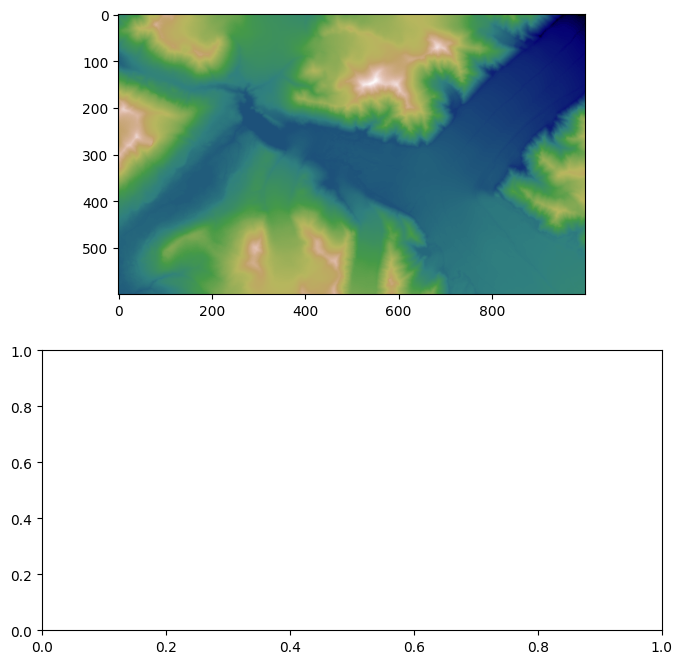

In [16]:
if 8 in do_steps:
    print('Doing Step 8...')
    try:
        tmp = pile.ts.shape
    except:
        pile = DemPile()
        pile.read_config(inipath)
        pile.load_pickle()
    # gp_kernel = ConstantKernel(constant_value=160, constant_value_bounds='fixed') * RationalQuadratic(
    #                                 length_scale=1.2, alpha=0.1, alpha_bounds='fixed', length_scale_bounds='fixed')
    # pile.viz(min_samples=min_samples, reg_method='gp', gp_kernel=gp_kernel, use_bitmask_only=True)
    # pile.viz(min_samples=min_samples, reg_method='gp', use_bitmask_only=True)
    # gp_kernel = ConstantKernel(constant_value=160, constant_value_bounds='fixed') * RationalQuadratic(
    #                            length_scale=1.2, alpha=0.1, alpha_bounds='fixed', length_scale_bounds='fixed') + WhiteKernel(
    #                            noise_level=1.0**2, noise_level_bounds='fixed')
    pile.viz(evmd_threshold=18, min_samples=3, reg_method='gp', use_bitmask_only=False, use_evmd_only=False)
else:
    print('Step 8 skipped')

## Step 9: Judge: boundary, timing, and maximum elevation change

In [17]:
def gp_get_event_dh_timing(a, eps=20, min_samples=3, gp_kernel=None):
    """
    a: carst.PixelTimeSeries object
    """
    xx = a.get_date()
    yy = a.get_value()
    ye = a.get_uncertainty()
    # ====
    # good_idx = a.bitmask_labels == 0
    exitstate, evmd_labels = a.do_evmd(eps=eps, min_samples=min_samples)
    good_idx = np.logical_and(a.bitmask_labels == 0, evmd_labels >= 0)
    # ====
    if not np.any(good_idx):
        max_negative_dh = np.nan
        max_negative_timing = np.nan
        return max_negative_dh, max_negative_timing
    
    xx_gp = xx[good_idx]
    yy_gp = yy[good_idx]
    ye_gp = ye[good_idx]
    xx_gp_yr = xx_gp / 365
    xx_gp_yr = xx_gp_yr.reshape(-1, 1)
    if gp_kernel is None:
        gp_kernel = ConstantKernel(constant_value=160, constant_value_bounds='fixed') * RationalQuadratic(
                                   length_scale=1.2, alpha=0.1, alpha_bounds='fixed', length_scale_bounds='fixed')
    # alpha = np.median(ye_gp) ** 2
    alpha = ye_gp ** 2
    x_pred_pos, mean_prediction, std_prediction, optimized_kernel = gpr(xx_gp_yr, yy_gp, kernel=gp_kernel, alpha=alpha)
    
    localmax_pos = argrelextrema(mean_prediction, np.greater)
    localmax_pos = localmax_pos[0]
    
    localmin_pos = argrelextrema(mean_prediction, np.less)
    localmin_pos = localmin_pos[0]

    ## Add head and tail to the local_pos ####

    if localmin_pos.any() and localmax_pos.any():
        if localmin_pos[0] < localmax_pos[0]:
            localmax_pos = np.insert(localmax_pos, 0, 0)
        else:
            localmin_pos = np.insert(localmin_pos, 0, 0)
    
        if localmin_pos[-1] < localmax_pos[-1]:
            localmin_pos = np.append(localmin_pos, mean_prediction.size - 1)
        else:
            localmax_pos = np.append(localmax_pos, mean_prediction.size - 1)
    elif localmin_pos.any() or localmax_pos.any():
        if localmin_pos:
            localmax_pos = np.insert(localmax_pos, 0, 0)
            localmax_pos = np.append(localmax_pos, mean_prediction.size - 1)
        else:
            localmin_pos = np.insert(localmin_pos, 0, 0)
            localmin_pos = np.append(localmin_pos, mean_prediction.size - 1)

    ##########################################
    
    x_pred_pos = x_pred_pos.flatten()
    index_spacing = np.round(1.5 / (x_pred_pos[1] - x_pred_pos[0]))    # 1.5 years
    index_spacing = index_spacing.astype(int)
    
    maxmin_pairs = []
    for maxpeak_pos in localmax_pos:
        proximity = np.abs(maxpeak_pos - localmin_pos) <=  index_spacing
        if np.any(proximity):
            for minpeak_pos in localmin_pos[proximity]:
                if maxpeak_pos > minpeak_pos:
                    maxmin_pairs.append([minpeak_pos, maxpeak_pos])
                else:
                    maxmin_pairs.append([maxpeak_pos, minpeak_pos])
                    
    if maxmin_pairs:
        dh_list = []
        for pair in maxmin_pairs:
            elev = mean_prediction[pair]
            elev_change = elev[1] - elev[0]
            dh_list.append(elev_change)

        max_negative_pos = np.argmin(dh_list)
        max_negative_dh = dh_list[max_negative_pos]
        max_negative_timing = x_pred_pos[maxmin_pairs[max_negative_pos][0]] + 2015
    else:
        max_negative_dh = np.nan
        max_negative_timing = np.nan
    
    return max_negative_dh, max_negative_timing

In [18]:
# %%time
# drain_dh_map = np.full_like(pile.ts, np.nan, dtype=float)
# drain_t_map =  np.full_like(pile.ts, np.nan, dtype=float)

# for m in range(pile.ts.shape[0]):
#     pile.display_progress(m, pile.ts.shape[0])
#     for n in range(pile.ts.shape[1]):
#         gp_kernel = ConstantKernel(constant_value=160, constant_value_bounds='fixed') * RationalQuadratic(
#                                    length_scale=1.2, alpha=0.1, alpha_bounds='fixed', length_scale_bounds='fixed')
#         base_eps = 2 
#         min_samples = 3
#         max_negative_dh, max_negative_timing = gp_get_event_dh_timing(pile.ts[m, n], eps=base_eps, min_samples=min_samples, gp_kernel=gp_kernel)
#         drain_dh_map[m, n] = max_negative_dh
#         drain_t_map[m, n] = max_negative_timing

In [19]:
# drain_eps_map =  np.full_like(pile.ts, base_eps, dtype=float)
# max_eps = 20
# dh_max_diff_allowance = 1.0

# # Needs to adjust m and n ranges
# for m in range(170, 390):
#     pile.display_progress(m, pile.ts.shape[0])
#     for n in range(210, 610):
#         dh_vary_eps_list = np.array([np.nan for i in range(base_eps, max_eps)])
#         for eps_i in range(base_eps, max_eps):
#             dh_vary_eps_list[eps_i - base_eps], _ = gp_get_event_dh_timing(pile.ts[m, n], eps=eps_i, min_samples=min_samples, gp_kernel=gp_kernel)
#         good_eps_list = np.where(dh_vary_eps_list - np.nanmin(dh_vary_eps_list) < dh_max_diff_allowance)
#         good_eps_min = good_eps_list[0][0] + base_eps
#         max_negative_dh, max_negative_timing = gp_get_event_dh_timing(pile.ts[m, n], eps=good_eps_min, min_samples=min_samples, gp_kernel=gp_kernel)
#         drain_dh_map[m, n] = max_negative_dh
#         drain_t_map[m, n] = max_negative_timing
#         drain_eps_map[m, n] = good_eps_min

In [20]:
# drain_dh_map_raster = SingleRaster(f"{dhdt_prefix}_drain-evmd-iter1_dh.tif")
# drain_t_map_raster = SingleRaster(f"{dhdt_prefix}_drain-evmd-iter1_t.tif")

# drain_dh_map_raster.Array2Raster(drain_dh_map, pile.refgeo)
# drain_t_map_raster.Array2Raster(drain_t_map, pile.refgeo)

In [21]:
# drain_dh_map_raster = SingleRaster(f"{dhdt_prefix}_drain-evmd-iter2_dh.tif")
# drain_t_map_raster = SingleRaster(f"{dhdt_prefix}_drain-evmd-iter2_t.tif")
# drain_eps_map_raster = SingleRaster(f"{dhdt_prefix}_drain-evmd-iter2_eps.tif")

# drain_dh_map_raster.Array2Raster(drain_dh_map, pile.refgeo)
# drain_t_map_raster.Array2Raster(drain_t_map, pile.refgeo)
# drain_eps_map_raster.Array2Raster(drain_eps_map, pile.refgeo)

Doing Step 9...
0/600 lines processed
100/600 lines processed
200/600 lines processed
300/600 lines processed
400/600 lines processed
500/600 lines processed


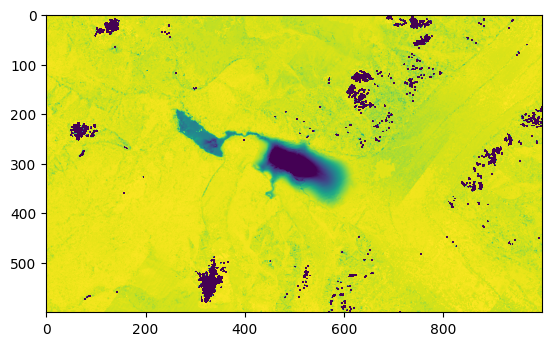

In [22]:
if 9 in do_steps:
    print('Doing Step 9...')

    drain_eps_zones_raster = SingleRaster(f"{tag}-drain-eps-zones.tif")
    drain_eps_zones = drain_eps_zones_raster.ReadAsArray()
    # plt.imshow(drain_eps_zones)
    # plt.show()

    drain_dh_map = np.full_like(pile.ts, np.nan, dtype=float)
    drain_t_map =  np.full_like(pile.ts, np.nan, dtype=float)
    
    for m in range(pile.ts.shape[0]):
        pile.display_progress(m, pile.ts.shape[0])
        for n in range(pile.ts.shape[1]):
            gp_kernel = ConstantKernel(constant_value=160, constant_value_bounds='fixed') * RationalQuadratic(
                                       length_scale=1.2, alpha=0.1, alpha_bounds='fixed', length_scale_bounds='fixed')
            min_samples = 3
            max_negative_dh, max_negative_timing = gp_get_event_dh_timing(pile.ts[m, n], eps=drain_eps_zones[m, n], min_samples=min_samples, gp_kernel=gp_kernel)
            drain_dh_map[m, n] = max_negative_dh
            drain_t_map[m, n] = max_negative_timing

    drain_dh_map_raster = SingleRaster(f"{dhdt_prefix}_drain-evmd-finalzone_dh.tif")
    drain_t_map_raster = SingleRaster(f"{dhdt_prefix}_drain-evmd-finalzone_t.tif")
    
    drain_dh_map_raster.Array2Raster(drain_dh_map, pile.refgeo)
    drain_t_map_raster.Array2Raster(drain_t_map, pile.refgeo)

    plt.imshow(drain_dh_map, clim=(-50, 0)) #, cmap='gist_earth')

else:
    print('Step 9 skipped')